In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# pip install tensorflow_addons

In [ ]:
import os
os.chdir("d:\\OneDrive_VT\\OneDrive - Virginia Tech\\Research\\Codes\\research\\PigBW\\Pig_BW_beta\\DL\\Vit")
os.getcwd()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd


In [ ]:
## Read into labelled depth iamges
## label process is in SimpleCNN.ipynb
labelled_depth = pd.read_csv("../labelled_depth.csv")
pens = np.unique(labelled_depth["Pen"])


In [ ]:
# labelled_depth = labelled_depth[labelled_depth["Pen"]=="pen1top"]

In [ ]:
labelled_depth

In [ ]:
image_size = 80

In [ ]:

# Set the path to your image folder
# List all files
def read_images(labelled_depth):
    images = []
    for filename in labelled_depth["FilePath"]:
        if filename.endswith('.png'):  # Check the file format
            img_path = filename
            img = Image.open(img_path).convert('L')  # 'L' mode means grayscale
            images.append(img)

    # Convert images to array and resize
    image_size = 80
    processed_images = np.array([img_to_array(img.resize((image_size, image_size))) for img in images])

    # Normalize the image data
    processed_images = processed_images / 255.0
    return processed_images


In [ ]:
pig_n = np.unique(labelled_depth['Bag_ID']).shape[0]

In [ ]:
import random
train_bag_id = random.sample(list(np.unique(labelled_depth["Bag_ID"])), int(pig_n*0.8))

train_df = labelled_depth[labelled_depth["Bag_ID"].isin(train_bag_id)]
test_df = labelled_depth[-labelled_depth["Bag_ID"].isin(train_bag_id)]

In [ ]:
# Convert weight array to a NumPy array
# weights = [np.random.randint(0, 100) for i in range(processed_images.shape[0])] #要改成实际输入的weight

# # Split the dataset
# x_train, x_test, y_train, y_test = train_test_split(processed_images, weights, test_size=0.2, random_state=42)
# y_train = y_train.astype(np.float32)
# y_test = y_test.astype(np.float32)


In [ ]:
train_df.shape

In [ ]:
x_train = read_images(labelled_depth=train_df)
print(x_train.shape)
y_train = train_df["Weights"].values
y_train = y_train.astype(np.float32)
print(y_train.shape)


In [ ]:
x_test = read_images(labelled_depth=test_df)
print(x_test.shape)
y_test = test_df["Weights"].values
y_test = y_test.astype(np.float32)
print(y_test.shape)

In [ ]:
num_classes = 1
input_shape = (image_size, image_size, 1)

In [66]:
# Configure hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 100
num_epochs = 100
patience = 5
image_size = image_size
patch_size = 5
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]


In [67]:

# Data augmentation
# Uncomment and modify the following lines if data augmentation is needed

# Multilayer Perceptron (MLP)
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Layer to extract image patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Define Patch Encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Create ViT Regressor model
def create_vit_regressor():
    inputs = layers.Input(shape=input_shape)
    augmented = inputs
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    output = layers.Dense(1, activation='linear')(features)  # Linear activation function in output layer

    model = keras.Model(inputs=inputs, outputs=output)
    print(model.summary())
    return model

# Define Mean Squared Error loss function
def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define Mean Absolute Error metric
def mean_absolute_error(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Run regression experiment
# Define Mean Squared Error loss function
def mean_squared_error(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Define Mean Absolute Error metric
def mean_absolute_error(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

# Run regression experiment
def run_regression_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=mean_squared_error,
        metrics=[mean_squared_error]
    )

    checkpoint_filepath = "../tmp/checkpoint/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        patience=patience
    )

    hist = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )
    # Plot the training curve
    # plt.plot(hist.history['loss'])
    # plt.plot(hist.history['val_loss'])
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['train', 'val'], loc='upper right')
    # plt.show()
    # plt.plot(hist.history['accuracy'])
    # plt.plot(hist.history['val_accuracy'])
    # plt.title('Model accuracy')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['train', 'val'], loc='lower right')
    # plt.show()
    model.load_weights(checkpoint_filepath)
    test_loss, test_mae = model.evaluate(x_test, y_test)
    print(f"Test loss: {test_loss}")
    print(f"Test MAE: {test_mae}")

    return hist



In [68]:
# Create and run regression experiment with ViT regressor
vit_regressor = create_vit_regressor()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 patches_6 (Patches)            (None, None, 25)     0           ['input_7[0][0]']                
                                                                                                  
 patch_encoder_6 (PatchEncoder)  (None, 256, 64)     18048       ['patches_6[0][0]']              
                                                                                                  
 layer_normalization_102 (Layer  (None, 256, 64)     128         ['patch_encoder_6[0][0]']        
 Normalization)                                                                             

In [69]:
hist = run_regression_experiment(vit_regressor)

Epoch 1/100
344/344 [==============================] - 49s 127ms/step - loss: 574.9605 - mean_squared_error: 574.3420 - val_loss: 839.5051 - val_mean_squared_error: 827.9401
Epoch 2/100
344/344 [==============================] - 42s 123ms/step - loss: 122.1649 - mean_squared_error: 122.1279 - val_loss: 976.9123 - val_mean_squared_error: 974.3456
Epoch 3/100
344/344 [==============================] - 42s 122ms/step - loss: 84.7060 - mean_squared_error: 84.6934 - val_loss: 984.6431 - val_mean_squared_error: 981.9136
Epoch 4/100
344/344 [==============================] - 43s 125ms/step - loss: 77.2314 - mean_squared_error: 77.2518 - val_loss: 755.6774 - val_mean_squared_error: 754.1013
Epoch 5/100
344/344 [==============================] - 42s 123ms/step - loss: 74.3571 - mean_squared_error: 74.4129 - val_loss: 980.9828 - val_mean_squared_error: 978.2714
Epoch 6/100
344/344 [==============================] - 42s 123ms/step - loss: 69.4575 - mean_squared_error: 69.4739 - val_loss: 1155.436

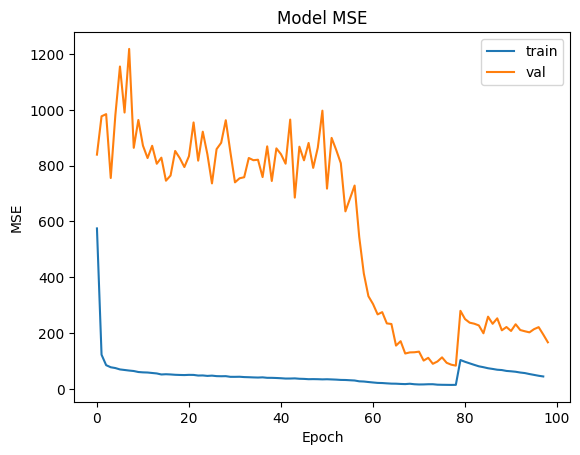

In [88]:
# Plot the training curve
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()


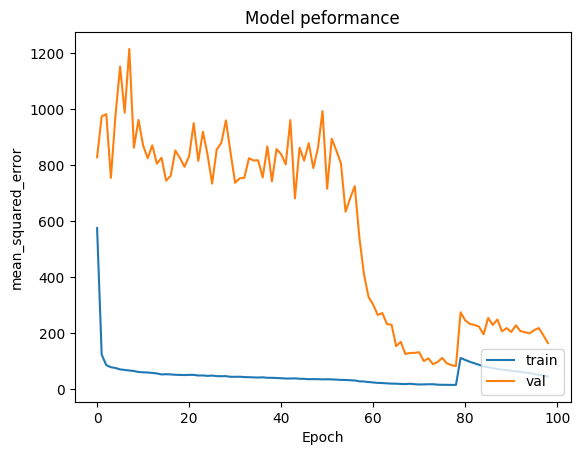

In [91]:
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('Model peformance')
plt.ylabel('mean_squared_error')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [92]:
test_loss, test_mae = vit_regressor.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test MAE: {test_mae}")

248/248 [==============================] - 4s 15ms/step - loss: 36.1729 - mean_squared_error: 36.1477
Test loss: 36.17290496826172
Test MAE: 36.147743225097656


In [93]:
predicted_weights = np.squeeze(vit_regressor.predict(x_test))
true_weights = y_test

248/248 [==============================] - 4s 15ms/step


In [94]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [96]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
print('METRICS ON ENTIRE DATASET:')
print('--------------------------')
# rmse = np.sqrt(cnn.evaluate(test_images, verbose=0))
rmse = mean_squared_error(true_weights, predicted_weights)**0.5
print("Test RMSE:\t{:.5f}".format(rmse))
r2 = r2_score(true_weights,predicted_weights)
print("Test R^2 Score:\t{:.5f}".format(r2))
MAPE = mape(true_weights, predicted_weights)
print("Test MAPE:\t{:.5f}%".format(MAPE))
print('--------------------------')

METRICS ON ENTIRE DATASET:
--------------------------
Test RMSE:	6.01439
Test R^2 Score:	0.70610
Test MAPE:	5.92023%
--------------------------
